In [1]:
from helpers import *
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import pickle as pkl
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from datetime import datetime
import seaborn as sns
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
pd.set_option('display.max_columns', None)

In [2]:

save_dir = ''
file_names = glob.glob(os.path.join(save_dir, f'QCEH_data/TCV_DATAno*.parquet'))

In [3]:
precomputed_dir = 'precomputed_data/'

List of dataframes (one discharge per each element of the list)

In [4]:
df_list = [pd.read_parquet(x) for x in file_names]
len(df_list)

60

# Initial Analysis - necessary values
For this project we are only focusing on the machine inputs provided in the data.

In [5]:
GENERAL_INPUTS = ["shotnumber", "time"]
MACHINE_INPUTS = ["isbaffled", "ip","b0","nel","ptot","pdiv","q95","betan","kappa","deltaavg","deltaupp",
                  "deltalow","gapin","gapout","zmag","rmag","rmin","lpar_ot","zeff"]
LABEL = ["LHD_label"]
INPUTS = GENERAL_INPUTS + MACHINE_INPUTS + LABEL
len(INPUTS)

22

In [6]:
# This normalizes the X values.
X_train, y_train, column_names = get_training_data(include_time = False, include_shotnumber = False, shot_indices = list(range(55)))
X_test, y_test, _ = get_training_data(include_time = False, include_shotnumber = False, shot_indices = list(range(56, 60)))
X_train.shape

(571675, 19)

In [7]:
X_tensor_train = torch.tensor(X_train, dtype=torch.float32)
y_tensor_train = torch.tensor((y_train - 1).astype(int), dtype=torch.long)

X_tensor_test = torch.tensor(X_test, dtype=torch.float32)
y_tensor_test = torch.tensor((y_test - 1).astype(int), dtype=torch.long)

# SOFTMAX classification

In [8]:
class LogisticRegression(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(in_dim, out_dim)
    
    def forward(self, x):
        return self.linear(x)
    

In [9]:
input_dim = X_train.shape[1]  # Number of input features
output_dim = 3 # Number of output classes (binary classification)

model = LogisticRegression(input_dim, output_dim)

criterion = nn.CrossEntropyLoss()
num_epochs = 1000
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [10]:
train_losses = []
test_losses = []  
train_accuracies = []
test_accuracies = []
train_f1_scores = []
test_f1_scores = []

In [11]:

def multi_confusion_matrix(y_predicted, y_expected):
    """
    Function constructing a multiclass confusion matrix
    
    :param y_predicted: pd.Series containing the predicted labels
    :param y_expected: pd.Series containing the expected labels
    :return: pd.Dataframe containing the multiclass confusion matrix 
    with columns as true labels and rows are predicted labels
    """
    predicted_labels = y_predicted.unique()
    expected_labels = y_expected.unique()
    
    mtrx = pd.DataFrame(0, columns=expected_labels, index=expected_labels)
    
    for expected_label in expected_labels:
        for predicted_label in predicted_labels:
            count = sum((y_expected == expected_label) & (y_predicted == predicted_label))
            mtrx.at[predicted_label, expected_label] = count
    return mtrx

def diag(matrix):
    """
    Function retrieving the true values of a confusion matrix
    
    :param matrix: confusion matrix
    :return: list of all the diagonal values
    """
    if len(matrix.index) <= len(matrix.columns):
        zipped = zip(matrix.index, matrix.columns[:len(matrix.index)])
    else:
        zipped = zip(matrix.index[:len(matrix.columns)], matrix.columns)
    
    diag = []
    for idx,col in zipped:
        diag.append(matrix.at[idx,col])
    return diag

def multi_accuracy(matrix):
    """
    Function computing the accuracy associated with a confusion matrix
    :param matrix: confusion matrix
    :return: precision score
    """
    t = sum(diag(matrix))
    all = matrix.sum().sum()
    return t / all
    
def multi_precision(matrix):
    """
    Function computing the precision associated with a confusion matrix
    :param matrix: confusion matrix
    :return: precision score
    """
    tp = diag(matrix)
    pred_p = matrix.sum(axis=1)
    return (tp / pred_p).fillna(0)
def multi_recall(matrix):
    """
    Function computing the recall associated with a confusion matrix
    :param matrix: confusion matrix
    :return: recall score
    """
    tp = diag(matrix)
    acutal_p = matrix.sum(axis=0)
    return (tp / acutal_p).fillna(0)

def multi_f1_score(matrix):
    """
    Function computing the F1-score associated with a confusion matrix
    :param matrix: confusion matrix
    :return: F1-score
    """
    recall = multi_recall(matrix)
    precision = multi_precision(matrix)
    
    multiplied = recall.multiply(precision)
    summed =recall + precision
    return (2 * multiplied / summed).fillna(0)

In [12]:
for epoch in range(num_epochs):
    # Forward pass on training data
    outputs_train = model(X_tensor_train)
    loss_train = criterion(outputs_train, y_tensor_train)
    train_losses.append(loss_train.item()) 

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss_train.item():.4f}')

    # Evaluate on test data
    model.eval()
    with torch.no_grad():
        outputs_train = model(X_tensor_train)
        y_predicted = torch.argmax(outputs_train, dim=1)
        y_predicted = pd.Series(y_predicted)
        mtrx_train = multi_confusion_matrix(y_predicted + 1, y_train)
        train_f1_scores.append(multi_f1_score(mtrx_train))
        train_accuracies.append(multi_accuracy(mtrx_train))
        
        outputs_test = model(X_tensor_test)
        y_predicted = torch.argmax(outputs_test, dim=1)
        
        y_predicted = pd.Series(y_predicted)
        mtrx_test = multi_confusion_matrix(y_predicted + 1, y_test)
        test_f1_scores.append(multi_f1_score(mtrx_test))
        test_accuracies.append(multi_accuracy(mtrx_test))
        
    model.train()

Epoch [100/1000], Training Loss: 0.4329
Epoch [200/1000], Training Loss: 0.4025
Epoch [300/1000], Training Loss: 0.3915
Epoch [400/1000], Training Loss: 0.3863
Epoch [500/1000], Training Loss: 0.3836
Epoch [600/1000], Training Loss: 0.3819
Epoch [700/1000], Training Loss: 0.3809
Epoch [800/1000], Training Loss: 0.3801
Epoch [900/1000], Training Loss: 0.3795
Epoch [1000/1000], Training Loss: 0.3790


In [13]:
def sort_score_per_label(scores):
    l_mode_scores = []
    qce_h_mode_scores = []
    elmy_mode_scores = []
    
    for score in scores:
        l_mode_scores.append(score.loc[1])
        qce_h_mode_scores.append(score.loc[2])
        elmy_mode_scores.append(score.loc[3])
    return l_mode_scores, qce_h_mode_scores, elmy_mode_scores


In [14]:
l_mode_scores_tr, qce_h_mode_scores_tr, elmy_mode_scores_tr = sort_score_per_label(train_f1_scores)
l_mode_scores_ts, qce_h_mode_scores_ts, elmy_mode_scores_ts = sort_score_per_label(test_f1_scores)

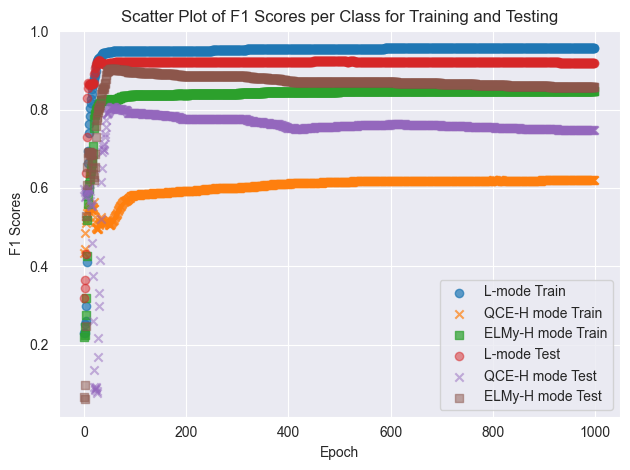

In [15]:
x = np.arange(len(l_mode_scores_tr))

plt.scatter(x, l_mode_scores_tr, label='L-mode Train', marker='o', alpha=0.7)
plt.scatter(x, qce_h_mode_scores_tr, label='QCE-H mode Train', marker='x', alpha=0.7)
plt.scatter(x, elmy_mode_scores_tr, label='ELMy-H mode Train', marker='s', alpha=0.7)


plt.scatter(x, l_mode_scores_ts, label='L-mode Test', marker='o', alpha=0.5)
plt.scatter(x, qce_h_mode_scores_ts, label='QCE-H mode Test', marker='x', alpha=0.5)
plt.scatter(x, elmy_mode_scores_ts, label='ELMy-H mode Test', marker='s', alpha=0.5)


plt.xlabel('Epoch')
plt.ylabel('F1 Scores')
plt.title('Scatter Plot of F1 Scores per Class for Training and Testing')

plt.legend()


plt.grid(True)
plt.tight_layout()
plt.show()

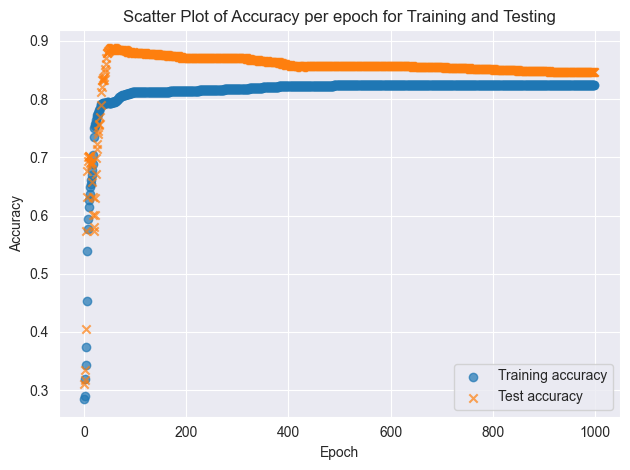

In [16]:
x = np.arange(len(train_accuracies))

plt.scatter(x, train_accuracies, label='Training accuracy', marker='o', alpha=0.7)
plt.scatter(x, test_accuracies, label='Test accuracy', marker='x', alpha=0.7)


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Scatter Plot of Accuracy per epoch for Training and Testing')

plt.legend()


plt.grid(True)
plt.tight_layout()
plt.show()

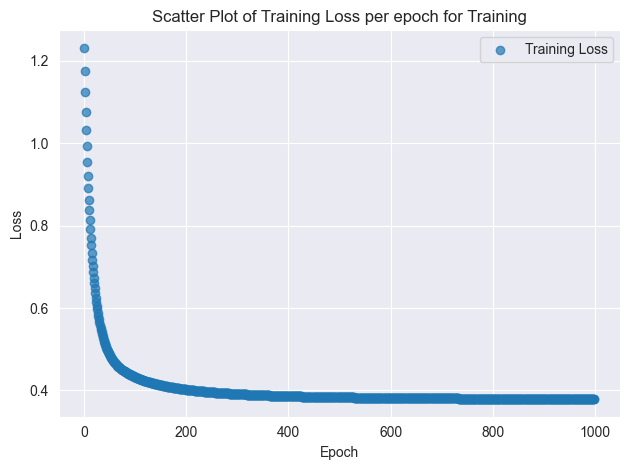

In [17]:
x = np.arange(len(train_losses))

plt.scatter(x, train_losses, label='Training Loss', marker='o', alpha=0.7)



plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Scatter Plot of Training Loss per epoch for Training')

plt.legend()


plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
test_f1_scores[-1]

1.0    0.919417
3.0    0.857266
2.0    0.747604
dtype: float64